In [0]:
import gdown
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms, datasets, models
from tqdm import tqdm
from tqdm.notebook import tqdm as tnb

from sklearn.metrics import accuracy_score, f1_score

In [2]:
url = 'https://drive.google.com/uc?export=download&confirm=KVq9&id=1UOXiteT4p-8fGBgPmxIB8fT9SsXVRiBj'
gdown.download(url,'Assignment 05.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=KVq9&id=1UOXiteT4p-8fGBgPmxIB8fT9SsXVRiBj
To: /content/Assignment 05.zip
5.96GB [02:04, 47.7MB/s]


'Assignment 05.zip'

In [3]:
!unzip Assignment\ 05.zip

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

## Computing Mean and Std of dataset

In [0]:
### Function by Shubhajit Das <https://forums.fast.ai/u/shubhajit/summary>
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [0]:
data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/train', 
                                     transform=data_transform)
valid_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/validation',
                                     transform=data_transform)
test_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/test',
                                    transform=data_transform)



In [0]:
train_l = torch.utils.data.DataLoader(train_dataset, batch_size=1000)
train_mean, train_std = online_mean_and_sd(train_l)

In [25]:
train_mean

[0.4907, 0.4907, 0.4908]

In [26]:
train_std

[0.2478, 0.2478, 0.2478]

## Preprocessing

In [0]:
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ])

data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ])

train_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/train', 
                                     transform=train_transform)
valid_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/validation',
                                     transform=data_transform)
test_dataset = datasets.ImageFolder(root='Assignment 5 Dataset/test',
                                    transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

## Helper functions for training and evaluating

In [0]:
device = torch.device("cuda:0")

In [0]:
def run_epoch(network, opt, criterion, loader, mode):
    running_loss = 0
    running_acc = 0

    if mode == "train":
        network.train()
    elif mode == "test":
        network.eval()
    else:
        raise ValueError("Undefined mode [train/test]")
    for i, data in tnb(enumerate(loader), total=len(loader), desc=mode, leave=False):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        opt.zero_grad()
        with torch.set_grad_enabled(mode == "train"):
            outputs = network(inputs)
            preds = torch.argmax(outputs, axis=1)
            loss = criterion(outputs, labels)

            if mode == "train":
                loss.backward()
                opt.step()

            running_loss += loss.item() * inputs.shape[0]
            running_acc += (preds == labels).sum().item()

    loss = running_loss / len(loader.dataset)
    acc = running_acc / len(loader.dataset)

    return loss, acc

def train_network(network, opt, criterion, train_loader, val_loader, 
                  epochs):
    stats = []
    best_acc = 0
    for epoch in tnb(range(epochs), desc="Training", total=epochs):
        # Train Model
        train_loss, train_acc = run_epoch(network, opt, 
                                    criterion, train_loader, mode="train")
        val_loss, val_acc = run_epoch(network, opt, 
                                criterion, val_loader, mode="test")
        stats.append((train_loss, train_acc, val_loss, val_acc))

        print("Epoch:", epoch+1, "| Train Acc", train_acc, "| Train Loss", 
          train_loss, "| Val Acc", val_acc, "| Val Loss", val_loss)
        if val_acc > best_acc:
            torch.save(network.state_dict(), PATH)
            best_acc = val_acc
    return stats

def network_predict(network, loader):
    labels_list = []
    preds_list = []
    network.eval()
    with torch.no_grad():
        for inputs, labels in tnb(loader, total=len(loader)):
            inputs = inputs.cuda()
            outputs = network(inputs)
            preds = torch.argmax(outputs, axis=1)
            labels_list += labels
            preds_list += preds.cpu()
    return labels_list, preds_list

def get_target_pred_imgs(network, dataset, true_class, pred_class, min_imgs):
    imgs = []
    lbls = []
    preds = []
    network.eval()
    with torch.no_grad():
        for d in dataset:
            image, label = d
            image, label = image.cuda(), torch.tensor(label).cuda()
            if label.item() == true_class:
                output = network(image[None, ...])
                pred = torch.argmax(output, axis=1)
                if pred.item() == pred_class:
                    imgs.append(image)
                    lbls.append(label)
                    preds.append(pred)
            if len(imgs) == min_imgs:
                break
    return imgs, lbls, preds

def display_image(imgs, ax):
    im1, im2 = imgs
    img1 = im1.cpu().numpy().transpose(1,2,0)
    img2 = im2.cpu().numpy().transpose(1,2,0)
    ax[0].imshow(img1)
    ax[1].imshow(img2)

## VGG16

### Part 1

In [0]:
model_vgg = models.vgg16(pretrained=True, progress=True)

In [0]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=120),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=120, out_features=2)
)
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
model_vgg = model_vgg.to(device)

In [13]:
for param in model_vgg.features.parameters():
    param.requires_grad=False

print("Parameters to update")
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        print(name)

Parameters to update
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


### Training

In [0]:
PATH = "task1_vgg.pkl"
optim = torch.optim.Adam(model_vgg.parameters())
criterion = nn.CrossEntropyLoss()

sts = train_network(model_vgg, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.8763333333333333 | Train Loss 0.33521756279468534 | Val Acc 0.8746666666666667 | Val Loss 0.2984247031211853


Epoch: 2 | Train Acc 0.8991666666666667 | Train Loss 0.26490988140304883 | Val Acc 0.8753333333333333 | Val Loss 0.29464348526795703


Epoch: 3 | Train Acc 0.9073333333333333 | Train Loss 0.24942491709192594 | Val Acc 0.886 | Val Loss 0.3101768742402395


Epoch: 4 | Train Acc 0.9100833333333334 | Train Loss 0.24276714584231376 | Val Acc 0.8886666666666667 | Val Loss 0.31316063515345255


Epoch: 5 | Train Acc 0.9141666666666667 | Train Loss 0.22787918463349344 | Val Acc 0.8926666666666667 | Val Loss 0.2999258341391881


Epoch: 6 | Train Acc 0.9161666666666667 | Train Loss 0.21614046828945477 | Val Acc 0.8906666666666667 | Val Loss 0.30191868646939596



### Training stats

Text(0.5, 1.0, 'Accuracy - FC Only')

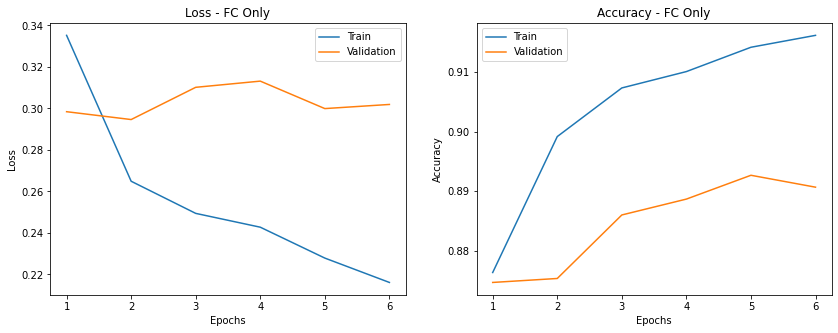

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - FC Only")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - FC Only")


### Test set evaluation

In [27]:
model_vgg.load_state_dict(torch.load("task1_vgg.pkl"))
y_true_train, y_pred_train = network_predict(model_vgg, train_loader)
y_true_valid, y_pred_valid = network_predict(model_vgg, validation_loader) 
y_true_test, y_pred_test = network_predict(model_vgg, test_loader)

In [28]:
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

Accuracy: 0.9526666666666667
F1-score: 0.9604015616285555


### Confusion Matrix

In [0]:
def conf_mat(y_true, y_pred):
    y_true = pd.Series(y_true, name="Actual")
    y_pred = pd.Series(y_pred, name="Predicted")
    y_true = y_true.apply(lambda x: x.item()).map({0:"Infected", 1:"Normal"})
    y_pred = y_pred.apply(lambda x: x.item()).map({0:"Infected", 1:"Normal"})
    display(pd.crosstab(y_true, y_pred))

#### Train

In [30]:
conf_mat(y_true_train, y_pred_train)

Predicted,Infected,Normal
Actual,,
Infected,4404,515
Normal,334,6747


#### Validation

In [31]:
conf_mat(y_true_valid, y_pred_valid)

Predicted,Infected,Normal
Actual,,
Infected,541,74
Normal,77,808


#### Test

In [32]:
conf_mat(y_true_test, y_pred_test)

Predicted,Infected,Normal
Actual,,
Infected,568,47
Normal,24,861


### Classified Images

#### Correctly classified

In [0]:
model_vgg.load_state_dict(torch.load("task1_vgg.pkl"))

<All keys matched successfully>

In [0]:
test_dataset.classes

['infected', 'normal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


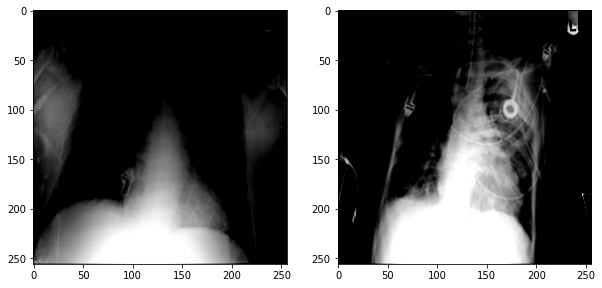

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 0, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


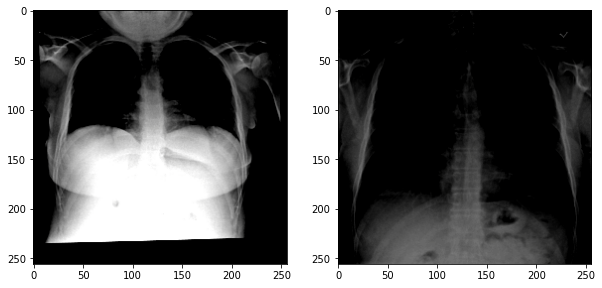

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 1, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

#### Wrongly classified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


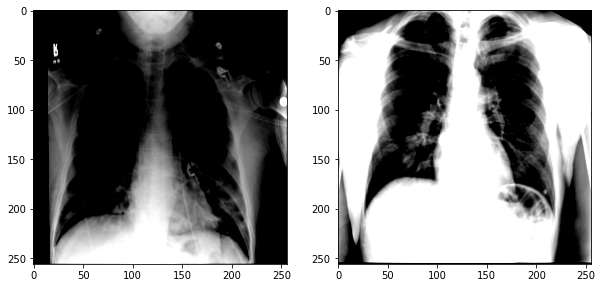

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 0, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


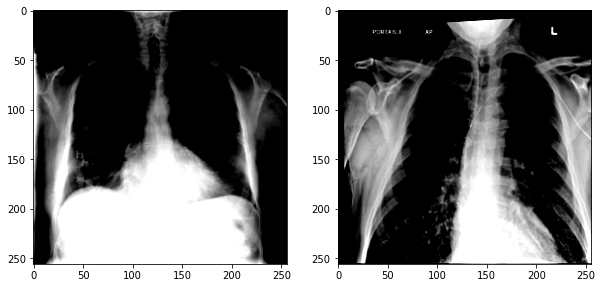

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 1, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

### Part 2

#### One convolutional layer

In [0]:
model_vgg = models.vgg16(pretrained=True, progress=True)

for param in model_vgg.parameters():
    param.requires_grad=False

model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=120),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=120, out_features=2)
)
for p in model_vgg.features[28].parameters():
    p.requires_grad=True

print("Parameters to update")
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        print(name)
model_vgg = model_vgg.cuda()

Parameters to update
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
PATH = "task2_vgg_one.pkl"
optim = torch.optim.Adam(model_vgg.parameters())
criterion = nn.CrossEntropyLoss()

sts_one_conv = train_network(model_vgg, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.9005833333333333 | Train Loss 0.27005409625172616 | Val Acc 0.8933333333333333 | Val Loss 0.24457318846384685


Epoch: 2 | Train Acc 0.9285833333333333 | Train Loss 0.19857039450109004 | Val Acc 0.9 | Val Loss 0.24717756136258442


Epoch: 3 | Train Acc 0.9380833333333334 | Train Loss 0.17285670247177282 | Val Acc 0.9046666666666666 | Val Loss 0.27821616586049397


Epoch: 4 | Train Acc 0.94275 | Train Loss 0.16350913036614656 | Val Acc 0.8966666666666666 | Val Loss 0.25967030388116835


Epoch: 5 | Train Acc 0.9505 | Train Loss 0.1398259157091379 | Val Acc 0.9033333333333333 | Val Loss 0.3284876425266266


Epoch: 6 | Train Acc 0.95425 | Train Loss 0.12782779645671447 | Val Acc 0.896 | Val Loss 0.2915056980450948



#### Training stats

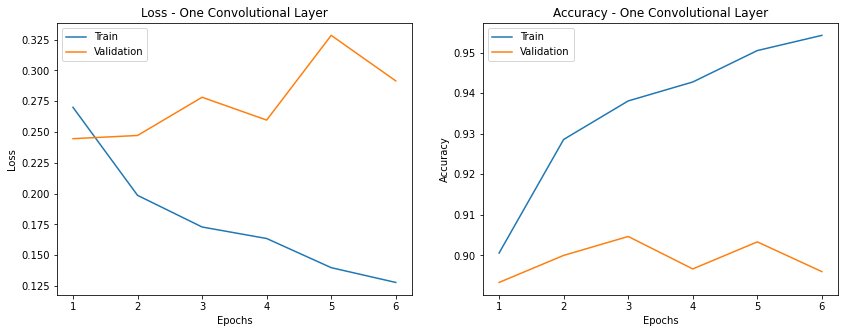

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_one_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - One Convolutional Layer")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - One Convolutional Layer");



#### Test set evaluation

In [0]:
model_vgg.load_state_dict(torch.load("task2_vgg_one.pkl"))
y_true_train, y_pred_train = network_predict(model_vgg, train_loader)
y_true_valid, y_pred_valid = network_predict(model_vgg, validation_loader) 
y_true_test, y_pred_test = network_predict(model_vgg, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)


Accuracy: 0.9606666666666667
F1-score: 0.9667979741136746
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4567,352
Normal,306,6775


Validation


Predicted,Infected,Normal
Actual,,
Infected,559,56
Normal,87,798


Test


Predicted,Infected,Normal
Actual,,
Infected,582,33
Normal,26,859


#### Few convolutional layers

In [0]:
model_vgg = models.vgg16(pretrained=True, progress=True)

for param in model_vgg.parameters():
    param.requires_grad=False

model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=120),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=120, out_features=2)
)
for i in range(24, 31):
    for p in model_vgg.features[i].parameters():
        p.requires_grad=True

print("Parameters to update")
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        print(name)
model_vgg = model_vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Parameters to update
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
PATH = "task2_vgg_few.pkl"
optim = torch.optim.Adam(model_vgg.parameters())
criterion = nn.CrossEntropyLoss()

sts_few_conv = train_network(model_vgg, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.86075 | Train Loss 0.34135806406537694 | Val Acc 0.892 | Val Loss 0.2522137951453527


Epoch: 2 | Train Acc 0.9245833333333333 | Train Loss 0.21110417405267556 | Val Acc 0.908 | Val Loss 0.24651605757077535


Epoch: 3 | Train Acc 0.93325 | Train Loss 0.1928749742259582 | Val Acc 0.9026666666666666 | Val Loss 0.22296956260999043


Epoch: 4 | Train Acc 0.9410833333333334 | Train Loss 0.18371220943828423 | Val Acc 0.9126666666666666 | Val Loss 0.22137343607346216


Epoch: 5 | Train Acc 0.9411666666666667 | Train Loss 0.1780369688520829 | Val Acc 0.9093333333333333 | Val Loss 0.3160113932887713


Epoch: 6 | Train Acc 0.9429166666666666 | Train Loss 0.16487280874202648 | Val Acc 0.91 | Val Loss 0.22262874066829683



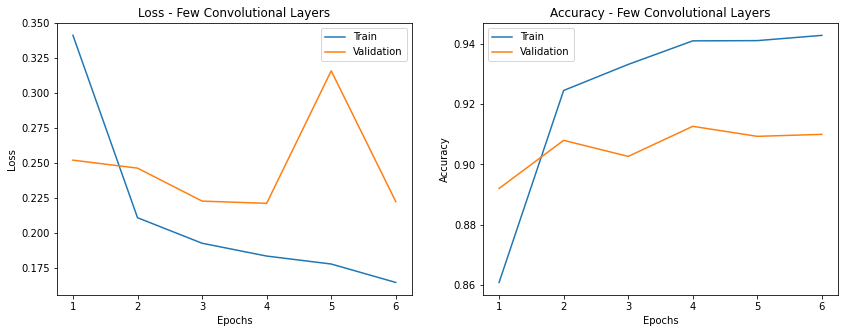

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_few_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - Few Convolutional Layers")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - Few Convolutional Layers");


In [0]:
model_vgg.load_state_dict(torch.load("task2_vgg_few.pkl"))
y_true_train, y_pred_train = network_predict(model_vgg, train_loader)
y_true_valid, y_pred_valid = network_predict(model_vgg, validation_loader) 
y_true_test, y_pred_test = network_predict(model_vgg, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)

Accuracy: 0.962
F1-score: 0.9683157309616454
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4449,470
Normal,141,6940


Validation


Predicted,Infected,Normal
Actual,,
Infected,533,82
Normal,58,827


Test


Predicted,Infected,Normal
Actual,,
Infected,572,43
Normal,14,871


#### Full network

In [33]:
model_vgg = models.vgg16(pretrained=True, progress=True)


model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=120),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=120, out_features=2)
)

print("Parameters to update")
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        print(name)
model_vgg = model_vgg.cuda()

Parameters to update
features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
PATH = "task2_vgg_full.pkl"
# optim = torch.optim.Adam(model_vgg.parameters())
optim = torch.optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

sts_full_conv = train_network(model_vgg, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.64675 | Train Loss 0.6364142470359803 | Val Acc 0.8193333333333334 | Val Loss 0.4478487492402395


Epoch: 2 | Train Acc 0.87225 | Train Loss 0.32447054573893547 | Val Acc 0.8713333333333333 | Val Loss 0.29758802288770675


Epoch: 3 | Train Acc 0.908 | Train Loss 0.25470702976981796 | Val Acc 0.8893333333333333 | Val Loss 0.2750988720258077


Epoch: 4 | Train Acc 0.9216666666666666 | Train Loss 0.2201785996754964 | Val Acc 0.908 | Val Loss 0.257738373319308


Epoch: 5 | Train Acc 0.9264166666666667 | Train Loss 0.20248190678159395 | Val Acc 0.9013333333333333 | Val Loss 0.259792218486468


Epoch: 6 | Train Acc 0.93 | Train Loss 0.18981747459371884 | Val Acc 0.896 | Val Loss 0.23913647862275442



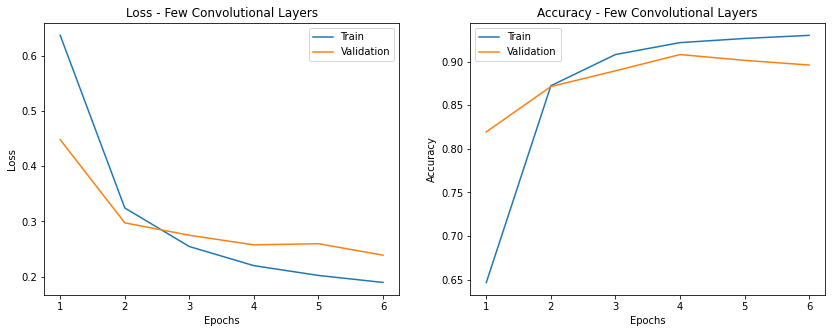

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_full_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - Few Convolutional Layers")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - Few Convolutional Layers");


In [35]:
model_vgg.load_state_dict(torch.load("task2_vgg_full.pkl"))
y_true_train, y_pred_train = network_predict(model_vgg, train_loader)
y_true_valid, y_pred_valid = network_predict(model_vgg, validation_loader) 
y_true_test, y_pred_test = network_predict(model_vgg, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)


Accuracy: 0.9733333333333334
F1-score: 0.9776286353467561
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4550,369
Normal,110,6971


Validation


Predicted,Infected,Normal
Actual,,
Infected,531,84
Normal,51,834


Test


Predicted,Infected,Normal
Actual,,
Infected,586,29
Normal,11,874


#### Classified Images

#### Correctly classified

In [0]:
model_vgg.load_state_dict(torch.load("task2_vgg_full.pkl"))

<All keys matched successfully>

In [0]:
test_dataset.classes

['infected', 'normal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


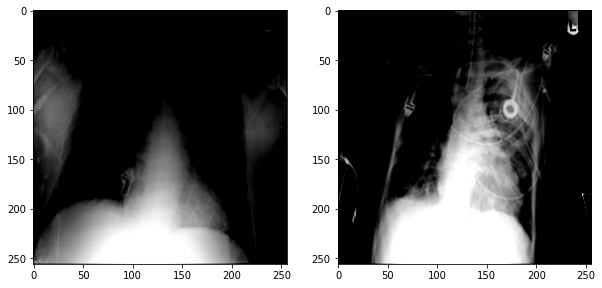

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 0, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


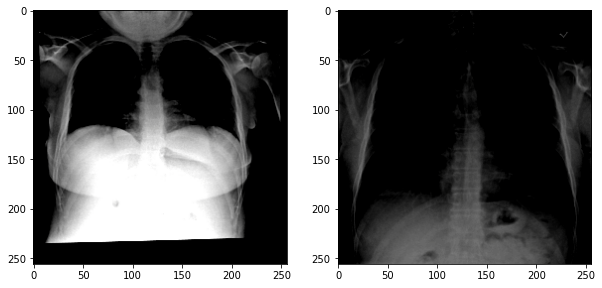

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 1, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

#### Wrongly classified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


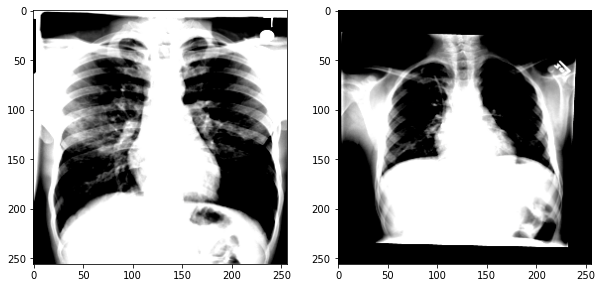

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 0, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


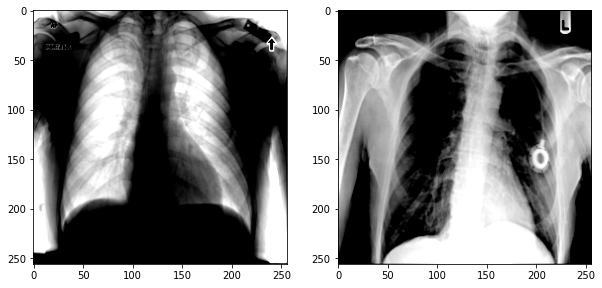

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_vgg.cuda(), test_dataset, 1, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

### Comparison of tasks - VGG16

In [0]:
def plot_on_ax(stats, ax, epochs, lbl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for s in stats:
        tr_loss, tr_acc, val_loss, val_acc = s
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    ax[0][0].plot(epochs, train_losses, label=lbl)
    ax[0][0].set_xlabel("Epochs")
    ax[0][0].set_ylabel("Train Loss")
    ax[0][0].legend()

    ax[0][1].plot(epochs, val_losses, label=lbl)
    ax[0][1].set_xlabel("Epochs")
    ax[0][1].set_ylabel("Val Loss")
    ax[0][1].legend()

    ax[1][0].plot(epochs, train_accs, label=lbl)
    ax[1][0].set_xlabel("Epochs")
    ax[1][0].set_ylabel("Train Accuracy")
    ax[1][0].legend()

    ax[1][1].plot(epochs, val_accs, label=lbl)
    ax[1][1].set_xlabel("Epochs")
    ax[1][1].set_ylabel("Val Accuracy")
    ax[1][1].legend()

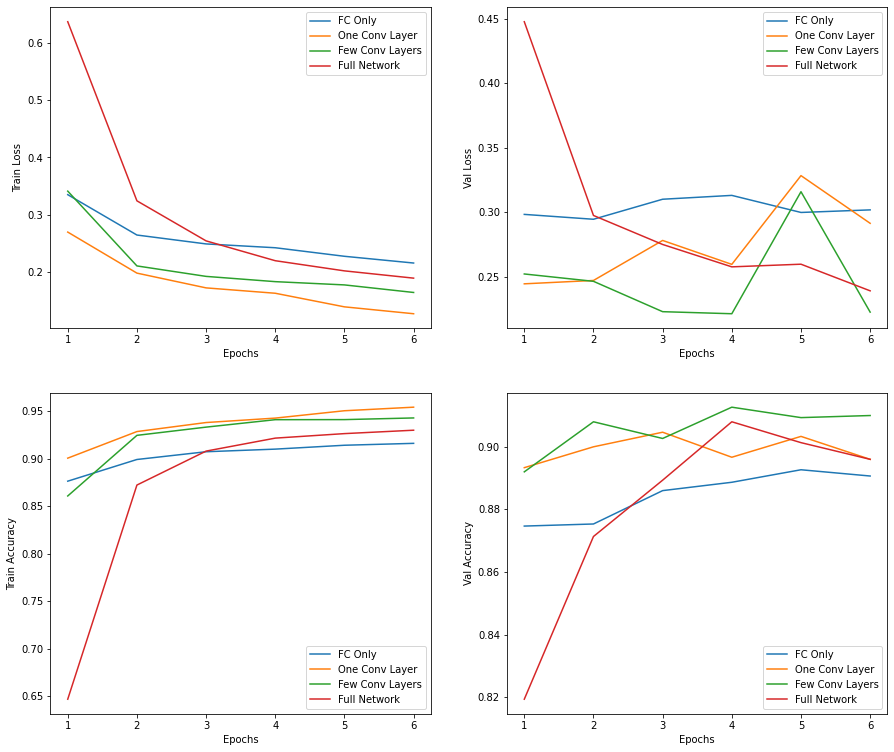

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(15,13))
epochs = range(1,7)

plot_on_ax(sts, ax, epochs, "FC Only")
plot_on_ax(sts_one_conv, ax, epochs, "One Conv Layer")
plot_on_ax(sts_few_conv, ax, epochs, "Few Conv Layers")
plot_on_ax(sts_full_conv, ax, epochs, "Full Network")

## Resnet-18

### Part 1

In [20]:
model_resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
for param in model_resnet.parameters():
    param.requires_grad=False

model_resnet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=2)
)

print("Parameters to update")
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

Parameters to update
fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [22]:
model_resnet = model_resnet.cuda()
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
PATH = "task1_resnet.pkl"
optim = torch.optim.Adam(model_resnet.parameters())
criterion = nn.CrossEntropyLoss()

sts = train_network(model_resnet, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.8439166666666666 | Train Loss 0.36889198861519495 | Val Acc 0.8413333333333334 | Val Loss 0.4158827203909556


Epoch: 2 | Train Acc 0.86675 | Train Loss 0.3221569903095563 | Val Acc 0.8533333333333334 | Val Loss 0.35303080809116366


Epoch: 3 | Train Acc 0.8773333333333333 | Train Loss 0.30054821811119714 | Val Acc 0.8486666666666667 | Val Loss 0.3572633184591929


Epoch: 4 | Train Acc 0.8728333333333333 | Train Loss 0.3080925833384196 | Val Acc 0.8506666666666667 | Val Loss 0.3561921229362488


Epoch: 5 | Train Acc 0.8780833333333333 | Train Loss 0.29715329337120056 | Val Acc 0.8526666666666667 | Val Loss 0.3379517803589503


Epoch: 6 | Train Acc 0.8809166666666667 | Train Loss 0.2909342640837034 | Val Acc 0.8586666666666667 | Val Loss 0.3388054989973704



### Training Curves

Text(0.5, 1.0, 'Accuracy - FC Only')

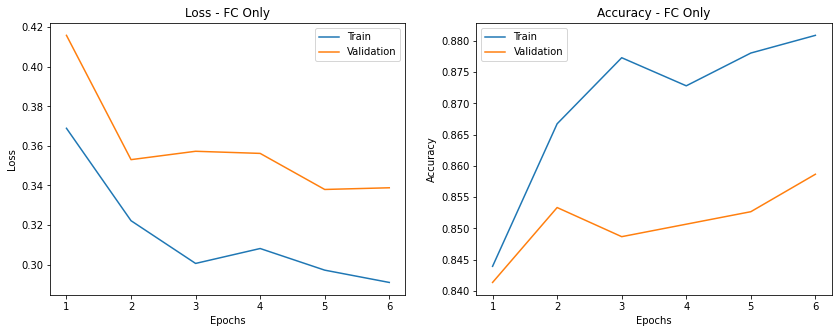

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - FC Only")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - FC Only")


In [23]:
model_resnet.load_state_dict(torch.load("task1_resnet.pkl"))
y_true_train, y_pred_train = network_predict(model_resnet, train_loader)
y_true_valid, y_pred_valid = network_predict(model_resnet, validation_loader) 
y_true_test, y_pred_test = network_predict(model_resnet, test_loader)

In [24]:
print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

Accuracy: 0.9253333333333333
F1-score: 0.9383259911894274


### Confusion Matrix

In [0]:
def conf_mat(y_true, y_pred):
    y_true = pd.Series(y_true, name="Actual")
    y_pred = pd.Series(y_pred, name="Predicted")
    y_true = y_true.apply(lambda x: x.item()).map({0:"Infected", 1:"Normal"})
    y_pred = y_pred.apply(lambda x: x.item()).map({0:"Infected", 1:"Normal"})
    display(pd.crosstab(y_true, y_pred))

#### Train

In [0]:
conf_mat(y_true_train, y_pred_train)

Predicted,Infected,Normal
Actual,,
Infected,4135,784
Normal,483,6598


#### Validation

In [0]:
conf_mat(y_true_valid, y_pred_valid)

Predicted,Infected,Normal
Actual,,
Infected,494,121
Normal,91,794


#### Test

In [0]:
conf_mat(y_true_test, y_pred_test)

Predicted,Infected,Normal
Actual,,
Infected,536,79
Normal,33,852


### Classified Images

#### Correctly classified

In [0]:
model_resnet.load_state_dict(torch.load("task1_resnet.pkl"))

In [0]:
test_dataset.classes

['infected', 'normal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


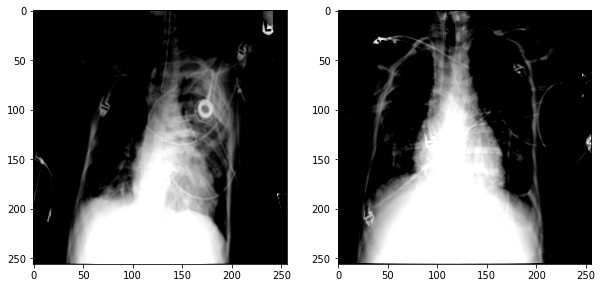

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 0, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


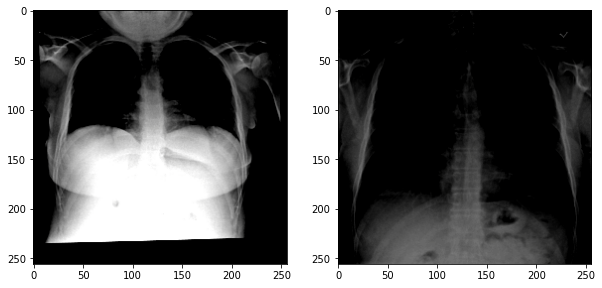

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 1, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

#### Wrongly classified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


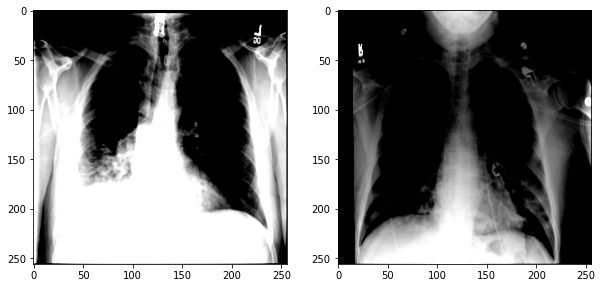

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 0, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


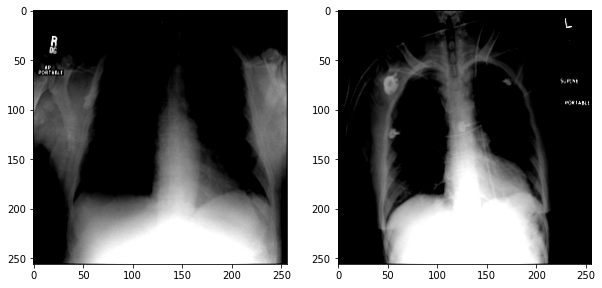

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 1, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

### Part 2

#### One Convolutional layer

In [0]:
model_resnet = models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad=False

model_resnet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=2)
)

for p in model_resnet.layer4[1].parameters():
    p.requires_grad = True

print("Parameters to update")
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

model_resnet = model_resnet.cuda()

Parameters to update
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [0]:
PATH = "task2_resnet_one.pkl"
optim = torch.optim.Adam(model_resnet.parameters())
criterion = nn.CrossEntropyLoss()

sts_one_conv = train_network(model_resnet, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.8988333333333334 | Train Loss 0.25352251970767975 | Val Acc 0.8893333333333333 | Val Loss 0.26838616267840065


Epoch: 2 | Train Acc 0.9245 | Train Loss 0.19971460217734177 | Val Acc 0.8846666666666667 | Val Loss 0.2758692642847697


Epoch: 3 | Train Acc 0.9335833333333333 | Train Loss 0.1751472858885924 | Val Acc 0.8806666666666667 | Val Loss 0.29419815651575726


Epoch: 4 | Train Acc 0.9406666666666667 | Train Loss 0.15974733266234398 | Val Acc 0.8986666666666666 | Val Loss 0.261266773780187


Epoch: 5 | Train Acc 0.95075 | Train Loss 0.1314178371578455 | Val Acc 0.8873333333333333 | Val Loss 0.28493033758799235


Epoch: 6 | Train Acc 0.9569166666666666 | Train Loss 0.11376146019995212 | Val Acc 0.8953333333333333 | Val Loss 0.318227551261584



#### Training curves

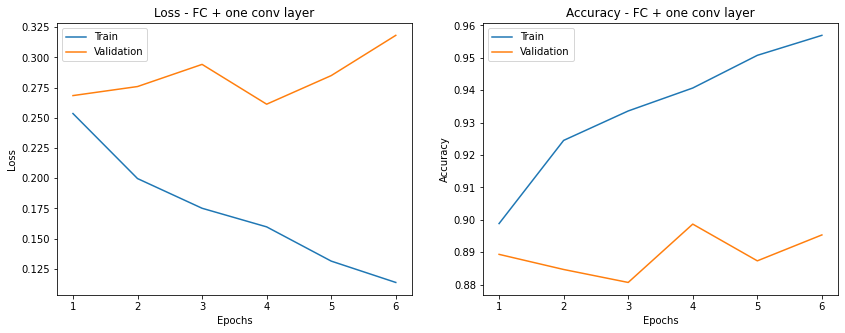

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_one_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - FC + one conv layer")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - FC + one conv layer");


In [0]:
model_resnet.load_state_dict(torch.load("task2_resnet_one.pkl"))
y_true_train, y_pred_train = network_predict(model_resnet, train_loader)
y_true_valid, y_pred_valid = network_predict(model_resnet, validation_loader) 
y_true_test, y_pred_test = network_predict(model_resnet, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)


Accuracy: 0.9573333333333334
F1-score: 0.9645232815964524
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4587,332
Normal,103,6978


Validation


Predicted,Infected,Normal
Actual,,
Infected,528,87
Normal,65,820


Test


Predicted,Infected,Normal
Actual,,
Infected,566,49
Normal,15,870


#### Few convolution layers

In [0]:
model_resnet = models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad=False

model_resnet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=2)
)

for p in model_resnet.layer3.parameters():
    p.requires_grad = True
    
for p in model_resnet.layer4.parameters():
    p.requires_grad = True

print("Parameters to update")
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

model_resnet = model_resnet.cuda()

Parameters to update
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [0]:
PATH = "task2_resnet_few.pkl"
optim = torch.optim.Adam(model_resnet.parameters())
criterion = nn.CrossEntropyLoss()

sts_few_conv = train_network(model_resnet, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.9163333333333333 | Train Loss 0.21961799905697504 | Val Acc 0.882 | Val Loss 0.2703260552883148


Epoch: 2 | Train Acc 0.9364166666666667 | Train Loss 0.1757057983080546 | Val Acc 0.904 | Val Loss 0.24220133749643963


Epoch: 3 | Train Acc 0.94225 | Train Loss 0.15792551550765832 | Val Acc 0.9113333333333333 | Val Loss 0.2416487361987432


Epoch: 4 | Train Acc 0.9490833333333333 | Train Loss 0.14080874348183472 | Val Acc 0.9173333333333333 | Val Loss 0.21669551266233125


Epoch: 5 | Train Acc 0.9535833333333333 | Train Loss 0.12672559002041817 | Val Acc 0.9153333333333333 | Val Loss 0.23690432500839234


Epoch: 6 | Train Acc 0.9573333333333334 | Train Loss 0.11273541804154714 | Val Acc 0.912 | Val Loss 0.2551455208857854



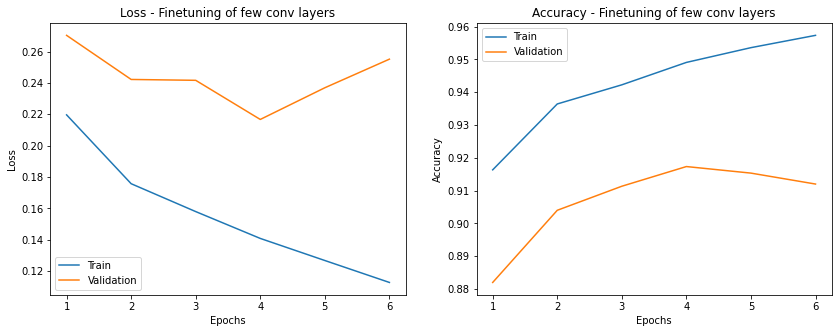

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_few_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - Finetuning of few conv layers")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - Finetuning of few conv layers");


In [0]:
model_resnet.load_state_dict(torch.load("task2_resnet_few.pkl"))
y_true_train, y_pred_train = network_predict(model_resnet, train_loader)
y_true_valid, y_pred_valid = network_predict(model_resnet, validation_loader) 
y_true_test, y_pred_test = network_predict(model_resnet, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)


Accuracy: 0.9653333333333334
F1-score: 0.9712070874861573
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4516,403
Normal,75,7006


Validation


Predicted,Infected,Normal
Actual,,
Infected,525,90
Normal,34,851


Test


Predicted,Infected,Normal
Actual,,
Infected,571,44
Normal,8,877


#### Full network

In [0]:
model_resnet = models.resnet18(pretrained=True)

model_resnet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=2)
)

print("Parameters to update")
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

model_resnet = model_resnet.cuda()

Parameters to update
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.b

In [0]:
PATH = "task2_resnet_full.pkl"
optim = torch.optim.Adam(model_resnet.parameters())
criterion = nn.CrossEntropyLoss()

sts_full_conv = train_network(model_resnet, optim, criterion, 
                    train_loader, validation_loader, 6)

Epoch: 1 | Train Acc 0.8961666666666667 | Train Loss 0.25895793437957765 | Val Acc 0.854 | Val Loss 0.39450213050842287


Epoch: 2 | Train Acc 0.922 | Train Loss 0.20553326272964478 | Val Acc 0.8973333333333333 | Val Loss 0.2523043005466461


Epoch: 3 | Train Acc 0.9269166666666667 | Train Loss 0.192069137553374 | Val Acc 0.8986666666666666 | Val Loss 0.2532680855592092


Epoch: 4 | Train Acc 0.9311666666666667 | Train Loss 0.17722843696673712 | Val Acc 0.9013333333333333 | Val Loss 0.23936040260394414


Epoch: 5 | Train Acc 0.9379166666666666 | Train Loss 0.16384036766986051 | Val Acc 0.904 | Val Loss 0.2574469602505366


Epoch: 6 | Train Acc 0.944 | Train Loss 0.15421766928831737 | Val Acc 0.908 | Val Loss 0.24376631454626718



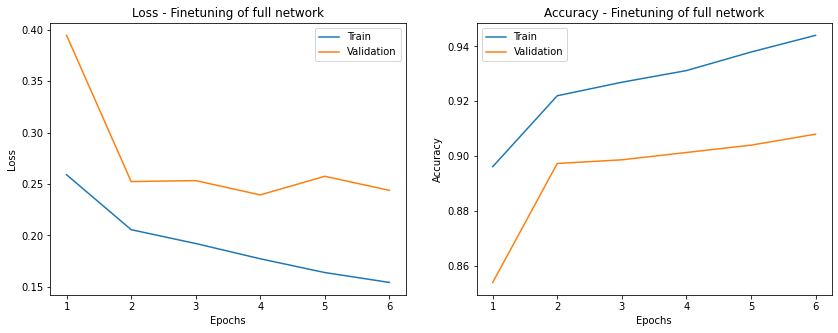

In [0]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for s in sts_full_conv:
    tr_loss, tr_acc, val_loss, val_acc = s
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
epochs = range(1,7)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(epochs, train_losses, label="Train")
ax[0].plot(epochs, val_losses, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("Loss - Finetuning of full network")
ax[1].plot(epochs, train_accs, label="Train")
ax[1].plot(epochs, val_accs, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy - Finetuning of full network");


In [0]:
model_resnet.load_state_dict(torch.load("task2_resnet_full.pkl"))
y_true_train, y_pred_train = network_predict(model_resnet, train_loader)
y_true_valid, y_pred_valid = network_predict(model_resnet, validation_loader) 
y_true_test, y_pred_test = network_predict(model_resnet, test_loader)

print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
print("F1-score:", f1_score(y_true_test, y_pred_test))

print("Confusion Matrices")
print("Train")
conf_mat(y_true_train, y_pred_train)
print("Validation")
conf_mat(y_true_valid, y_pred_valid)
print("Test")
conf_mat(y_true_test, y_pred_test)


Accuracy: 0.968
F1-score: 0.9730337078651685
Confusion Matrices
Train


Predicted,Infected,Normal
Actual,,
Infected,4540,379
Normal,233,6848


Validation


Predicted,Infected,Normal
Actual,,
Infected,552,63
Normal,75,810


Test


Predicted,Infected,Normal
Actual,,
Infected,586,29
Normal,19,866


#### Correctly classified

In [0]:
model_resnet.load_state_dict(torch.load("task2_resnet_full.pkl"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


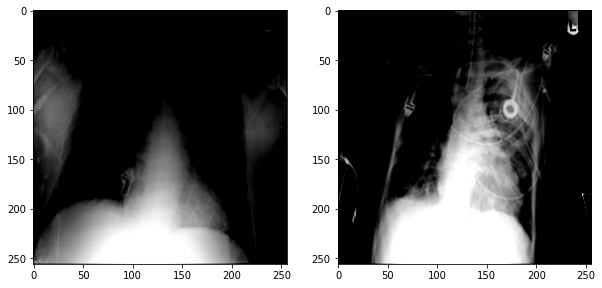

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 0, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


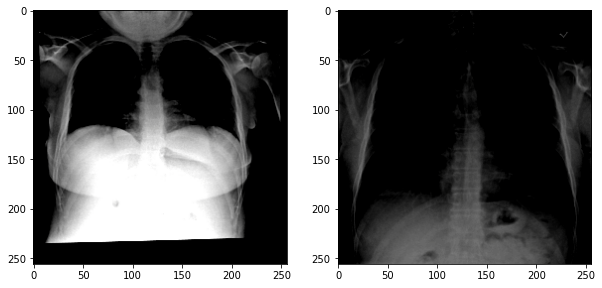

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 1, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

#### Wrongly classified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


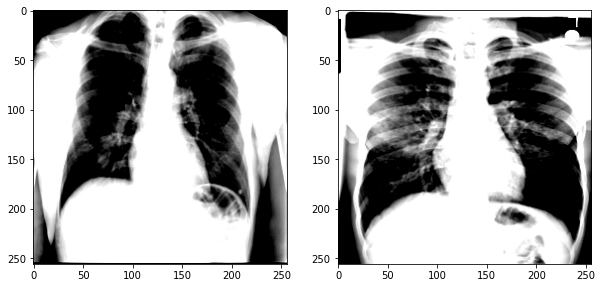

In [0]:
### Infected
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 0, 1, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


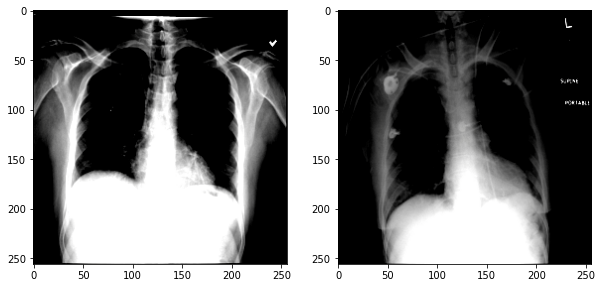

In [0]:
### Normal
imgs, lbls, preds = get_target_pred_imgs(model_resnet.cuda(), test_dataset, 1, 0, 2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
display_image(imgs, ax)

### Comparison of tasks - Resnet

In [0]:
def plot_on_ax(stats, ax, epochs, lbl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for s in stats:
        tr_loss, tr_acc, val_loss, val_acc = s
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    ax[0][0].plot(epochs, train_losses, label=lbl)
    ax[0][0].set_xlabel("Epochs")
    ax[0][0].set_ylabel("Train Loss")
    ax[0][0].legend()

    ax[0][1].plot(epochs, val_losses, label=lbl)
    ax[0][1].set_xlabel("Epochs")
    ax[0][1].set_ylabel("Val Loss")
    ax[0][1].legend()

    ax[1][0].plot(epochs, train_accs, label=lbl)
    ax[1][0].set_xlabel("Epochs")
    ax[1][0].set_ylabel("Train Accuracy")
    ax[1][0].legend()

    ax[1][1].plot(epochs, val_accs, label=lbl)
    ax[1][1].set_xlabel("Epochs")
    ax[1][1].set_ylabel("Val Accuracy")
    ax[1][1].legend()

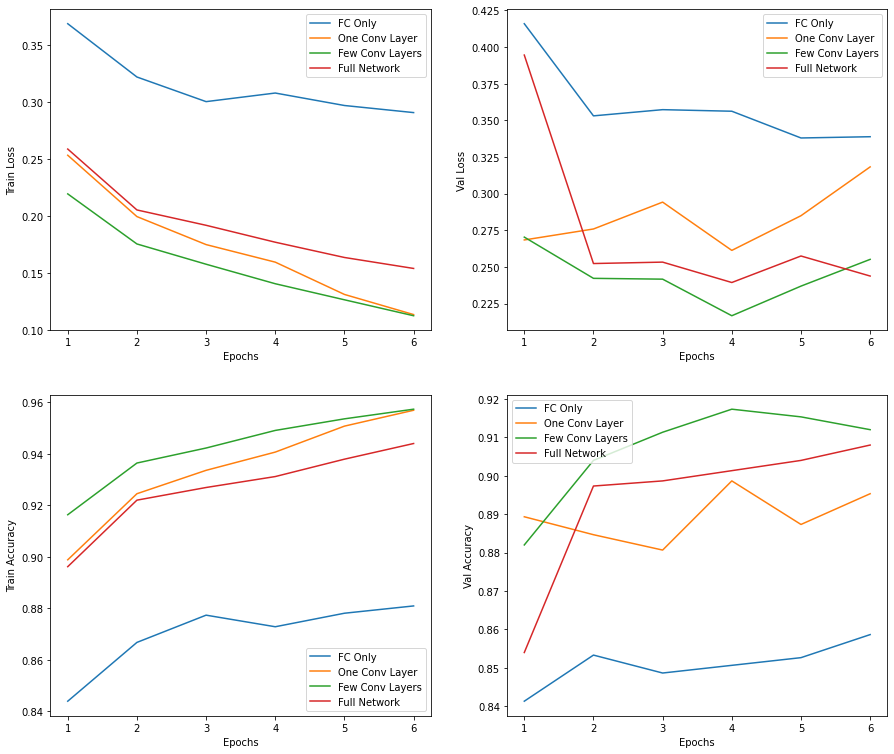

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(15,13))
epochs = range(1,7)

plot_on_ax(sts, ax, epochs, "FC Only")
plot_on_ax(sts_one_conv, ax, epochs, "One Conv Layer")
plot_on_ax(sts_few_conv, ax, epochs, "Few Conv Layers")
plot_on_ax(sts_full_conv, ax, epochs, "Full Network")